In [1]:
import torch
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from unet import UNet
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torchsummary import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
#FOR COMBINED DATASET OF POS AND NEG
# file = open('/home/turin/Documents/GitHub/long_term_underwater_vision/dataset/data', 'rb')
# np_data = pickle.load(file)
# file.close
# file = open('/home/turin/Documents/GitHub/long_term_underwater_vision/dataset/label', 'rb')
# np_label = pickle.load(file)
# file.close


In [3]:
#For Positive and Negative data separate
file1 = open('/home/turin/Documents/GitHub/long_term_underwater_vision/dataset/data_pos', 'rb')
pos_data = pickle.load(file1)
file1.close
im_pos, label_pos = pos_data

file1 = open('/home/turin/Documents/GitHub/long_term_underwater_vision/dataset/data_neg', 'rb')
neg_data = pickle.load(file1)
file1.close
im_neg, label_neg = neg_data

In [4]:
im_pos_reduced = im_pos[:64]
label_pos_reduced = label_pos[:64]
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(256,384), interpolation=transforms.InterpolationMode("nearest"))])
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data_path = "/home/turin/Documents/GitHub/long_term_underwater_vision/dataset/"
        img1_path = data_path+self.data[idx][0]
        img2_path = data_path+self.data[idx][1]
        img1 = transform(plt.imread(img1_path))
        img2 = transform(plt.imread(img2_path))
        label = self.labels[idx][0]
        pose_img1 = self.labels[idx][1]
        pose_img2 = self.labels[idx][2]
        return [img1, img2],[label, pose_img1, pose_img2]

training_data = CustomDataset(im_pos_reduced,label_pos_reduced)
train_dataloader = DataLoader(training_data, batch_size=4, shuffle=False, num_workers=16)

In [5]:
batch  = iter(train_dataloader)
bl2 = next(batch)
image = bl2[0]
label = bl2[1]
label[:][0], label[:][1][0]

(tensor([1, 1, 1, 1]),
 tensor([[[-0.6514, -0.5803, -0.4888, 39.7535],
          [-0.7499,  0.5904,  0.2984, 73.7323],
          [ 0.1154,  0.5609, -0.8198,  6.6106],
          [ 0.0000,  0.0000,  0.0000,  1.0000]],
 
         [[-0.6514, -0.5803, -0.4888, 39.7535],
          [-0.7499,  0.5904,  0.2984, 73.7323],
          [ 0.1154,  0.5609, -0.8198,  6.6106],
          [ 0.0000,  0.0000,  0.0000,  1.0000]],
 
         [[-0.6514, -0.5803, -0.4888, 39.7535],
          [-0.7499,  0.5904,  0.2984, 73.7323],
          [ 0.1154,  0.5609, -0.8198,  6.6106],
          [ 0.0000,  0.0000,  0.0000,  1.0000]],
 
         [[-0.6514, -0.5803, -0.4888, 39.7535],
          [-0.7499,  0.5904,  0.2984, 73.7323],
          [ 0.1154,  0.5609, -0.8198,  6.6106],
          [ 0.0000,  0.0000,  0.0000,  1.0000]]], dtype=torch.float64))

In [6]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.mse_loss(output1,output2)
        loss1 = euclidean_distance
        z = torch.clamp(euclidean_distance,min=0,max=3 )
        loss2 = 3 - z
        if label[0]:
            print(1, loss1)
        else:
            print(0, z)
        loss = label[0]*loss1 + (1-label[0])*loss2

        # loss = torch.mean( label * torch.pow(euclidean_distance, 2) +
        #                   (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss
criterion = ContrastiveLoss()
#criterion = nn.ContrastiveLoss()

In [7]:
# criterion(image[0][4], image[1][4], label[0][4]), criterion(image[0][1], image[1][1], label[0][1])
# F.mse_loss(image[0][1], image[1][1])

In [8]:
def create_model():
    model = torchvision.models.resnet18(pretrained=False, num_classes=2)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    model2 = UNet(in_channels=3,
             out_channels=1,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2)
    return model2
m = create_model()
m.cuda()
summary(m,(3,256,384))

/home/turin/.conda/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/turin/.conda/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 384]             896
              ReLU-2         [-1, 32, 256, 384]               0
       BatchNorm2d-3         [-1, 32, 256, 384]              64
            Conv2d-4         [-1, 32, 256, 384]           9,248
              ReLU-5         [-1, 32, 256, 384]               0
       BatchNorm2d-6         [-1, 32, 256, 384]              64
         MaxPool2d-7         [-1, 32, 128, 192]               0
         DownBlock-8  [[-1, 32, 128, 192], [-1, 32, 256, 384]]               0
            Conv2d-9         [-1, 64, 128, 192]          18,496
             ReLU-10         [-1, 64, 128, 192]               0
      BatchNorm2d-11         [-1, 64, 128, 192]             128
           Conv2d-12         [-1, 64, 128, 192]          36,928
             ReLU-13         [-1, 64, 128, 192]               0
      BatchNorm2d-14    

In [123]:
from torchvision.models import resnet18
model_resnet = resnet18
#Lightning Model Creation
class LitResnet(pl.LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()
        self.hparams_lr = lr
        self.save_hyperparameters()
        self.model = create_model()

    def forward(self, x):
        out = self.model(x)
        return out
    def training_step(self, batch, batch_idx):
        x, y = batch
        print(torch.abs(x[0][7]-x[1][7]))
        loss = F.mse_loss(x[0][7],x[1][7])
        #print(x[0][7]-x[1][7])
        logits1 = self(x[0])
        logits2 = self(x[1])
        #print(y[0])
        #loss = criterion(logits1,logits2,y[0])
        if y[0]:
         loss = F.mse_loss(logits1,logits2)
        self.log("train_loss", loss)
        return loss
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams_lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        steps_per_epoch = 256 // 8
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

In [124]:
model = LitResnet(lr=0.5)
trainer = Trainer(
    max_epochs=3,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
    log_every_n_steps= 20
)

trainer.fit(model, train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 2.0 M 
-------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.888     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 MiB (GPU 0; 7.80 GiB total capacity; 6.53 GiB already allocated; 35.81 MiB free; 6.60 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
model = LitResnet.load_from_checkpoint("/home/turin/Documents/GitHub/long_term_underwater_vision/model/logs/lightning_logs/version_35/checkpoints/epoch=4-step=160.ckpt")
data = train_dataloader
x,y = data.dataset.__getitem__(1)
x = x[0]
img = x
img = torch.unsqueeze(img,0)
out = model(img)
out = torch.squeeze(out,0)
out = out.T
x = x.T

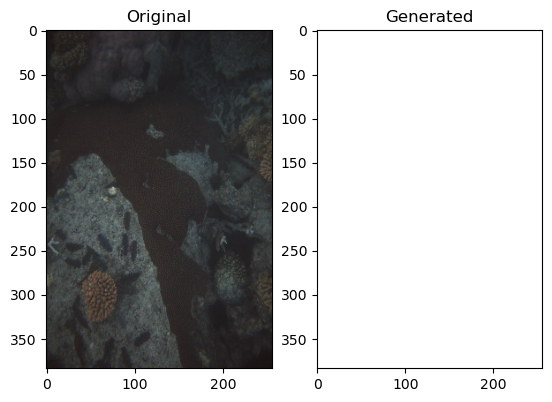

In [12]:
#Original Image
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(x.detach().numpy())
#Generated Image
plt.subplot(1,2,2)
plt.title("Generated")
plt.imshow(out.detach().numpy())

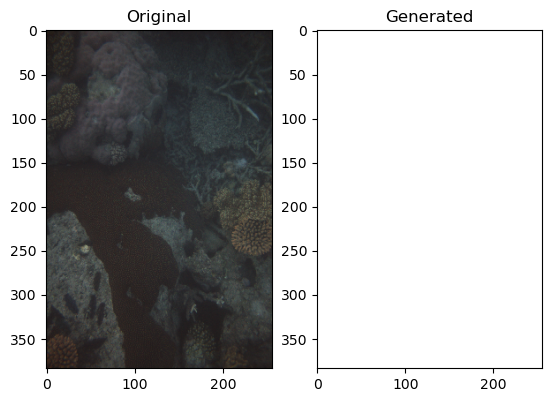

In [13]:
x,y = data.dataset.__getitem__(1)
x = x[1]
img = x
img = torch.unsqueeze(img,0)
out = model(img)
out = torch.squeeze(out,0)
out = out.T
x = x.T
#Original Image
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(x.detach().numpy())
#Generated Image
plt.subplot(1,2,2)
plt.title("Generated")
plt.imshow(out.detach().numpy())

In [14]:
vec = np.asarray([1.5,-3.4,2.1])
norm = np.linalg.norm(vec)
vec/norm


array([ 0.35141239, -0.79653476,  0.49197735])

In [15]:
torch.Tensor([1,3])


tensor([1., 3.])

In [16]:
pdist = nn.PairwiseDistance(p=2)
input1 = torch.randn(1,3,100, 128)
input2 = torch.randn(1,3,100, 128)
output = pdist(input1, input2)
output.mean(), input1.shape

(tensor(15.8951), torch.Size([1, 3, 100, 128]))

In [17]:
euclidean_distance = F.pairwise_distance(output1, output2, keepdim = False)
        #euclidean_distance = F.mse_loss(output1,output2)
        print(euclidean_distance.shape)

IndentationError: unexpected indent (3948995626.py, line 3)

In [ ]:
cc = torch.Tensor([1])

In [ ]:
if cc:
    print(12)

In [ ]:
cc.requires_grad_()

In [132]:
batch = iter(train_dataloader)
x,y = next(batch)
error = torch.abs(x[0][9]-x[1][9])
error.mean()

tensor(0.0860)

In [143]:
im1 = plt.imread("/home/turin/Documents/GitHub/long_term_underwater_vision/dataset/"+np_data[12][0])
im2 = plt.imread("/home/turin/Documents/GitHub/long_term_underwater_vision/dataset/"+np_data[12][1])

In [144]:
np.abs(im1-im2).mean(), np_label[12][0]

(0.057874657, 0)